In [8]:
import pandas as pd
import numpy as np
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv(
    'analcancer_cNMF/s13_cNMF_r10/s13_cNMF_r10.gene_spectra_score.k_9.dt_0_5.txt',
    sep='\t'
)

for col in ["Unnamed: 0", "index"]:
    if col in df.columns:
        df = df.drop(columns=col)

df.head()

,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,RNF223,C1orf159,TNFRSF18,...,ELANE,MCHR1,AC007244.1,CA14,UGT1A5,TMEM155,OPN4,GOLGA8R,CHRNE,ADAT3
0,-0.000123,0.000285,-0.000061,-0.000154,0.000139,-0.000118,0.000635,-0.000142,0.000030,0.000081,...,-0.000107,-0.000102,-0.000022,-0.000096,0.000092,-0.000091,-0.000069,-0.000031,-0.000070,0.000023
1,-0.000121,-0.000089,0.000017,-0.000347,-0.000320,0.000075,-0.000439,-0.000091,0.000012,0.000532,...,-0.000096,-0.000059,-0.000141,-0.000067,-0.000070,0.000417,-0.000001,-0.000063,-0.000008,-0.000062
2,-0.000062,-0.000072,0.000273,0.001272,-0.000258,-0.000269,-0.000593,-0.000196,0.000067,-0.000245,...,-0.000063,-0.000059,0.000157,-0.000071,-0.000020,-0.000052,-0.000045,-0.000059,0.000150,0.000101
3,0.000460,-0.000140,-0.000051,-0.000302,0.000030,-0.000046,-0.000203,-0.000063,-0.000069,-0.000161,...,0.000356,-0.000041,0.000022,-0.000042,-0.000020,-0.000056,0.000062,0.000045,-0.000005,-0.000037
4,-0.000053,-0.000130,-0.000116,-0.000266,-0.000169,0.000027,-0.000046,-0.000074,-0.000107,-0.000186,...,-0.000009,-0.000073,0.000003,-0.000059,-0.000028,-0.000085,-0.000040,0.000121,-0.000042,-0.000032


In [10]:
# --- Step 1: for each GEP (row), select top 10% genes (by column value) ---
n_genes = df.shape[1]
n_top = max(1, int(np.ceil(0.1 * n_genes)))
# dict: GEP_id -> set of top genes
top_genes_per_gep = {
    gep_id: set(row.nlargest(n_top).index)
    for gep_id, row in df.iterrows()
}

In [11]:
# --- Step 2: build membership matrix: genes (rows) × GEPs (cols), booleans ---
all_genes = list(df.columns)  # since columns are genes
geps = list(df.index.astype(str))
membership = pd.DataFrame(False, index=all_genes, columns=geps)

for gep_id, genes in top_genes_per_gep.items():
    # mark True for genes that are top in this GEP
    membership.loc[list(genes), str(gep_id)] = True

In [12]:
membership

,0,1,2,3,4,5,6,7,8
SAMD11,False,False,False,True,False,False,False,False,False
NOC2L,True,False,False,False,False,False,False,False,False
KLHL17,False,False,True,False,False,False,False,False,False
PLEKHN1,False,False,True,False,False,False,False,False,False
HES4,False,False,False,False,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...
TMEM155,False,True,False,False,False,False,False,False,False
OPN4,False,False,False,False,False,True,False,False,False
GOLGA8R,False,False,False,False,False,False,False,False,False
CHRNE,False,False,False,False,False,False,False,False,False


c:\Users\Sumedha\AppData\Local\Programs\Python\Python39\lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
c:\Users\Sumedha\AppData\Local\Programs\Python\Python39\lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

<Figure size 1200x700 with 0 Axes>

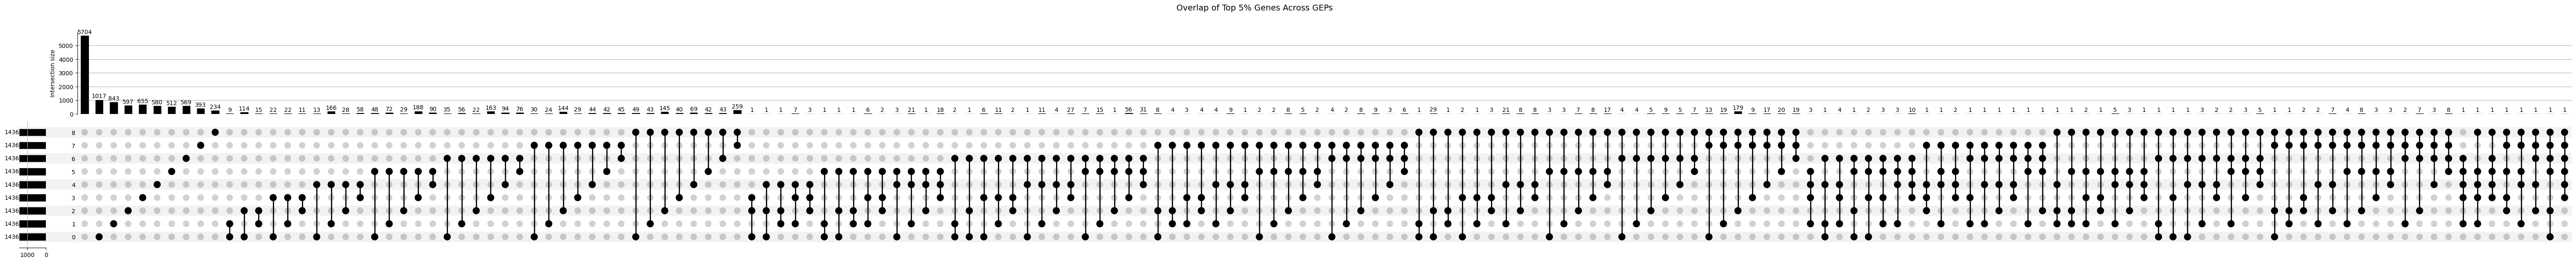

In [13]:
# --- Step 3: UpSet plot (Python UpSetR equivalent) ---
# upsetplot expects from_indicators(indicator_names, boolean_df)
upset_data = from_indicators(membership.columns, membership)

plt.figure(figsize=(12, 7))
UpSet(upset_data, show_counts=True).plot()
plt.suptitle("Overlap of Top 5% Genes Across GEPs", fontsize=14)
plt.show()

Genes appearing in the top 10% of exactly k GEPs:
1    5400
2    2379
3     748
4     120
5       6
6       2
7       0
8       0
9       0
Name: count, dtype: int64


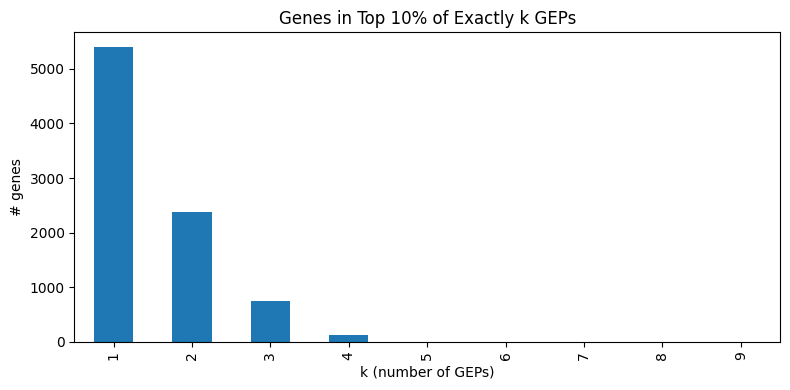

In [14]:
# --- Step 4: concise summary: “genes in top 10% of exactly k GEPs” ---
k_counts = membership.sum(axis=1).value_counts().sort_index()
k_counts = k_counts.reindex(range(1, len(geps) + 1), fill_value=0)

print("Genes appearing in the top 10% of exactly k GEPs:")
print(k_counts)

plt.figure(figsize=(8, 4))
k_counts.plot(kind='bar')
plt.xlabel("k (number of GEPs)")
plt.ylabel("# genes")
plt.title("Genes in Top 10% of Exactly k GEPs")
plt.tight_layout()
plt.show()
